In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
df_vaccinations = pd.read_csv('/kaggle/input/covid-vaccination-all-countries-data/vaccinations.csv', sep = ',')
df_tweets = pd.read_csv('/kaggle/input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv', sep = ',')

In [3]:
vaccinations = df_vaccinations.groupby('date')['daily_vaccinations'].sum().dropna().reset_index()
vaccinations.date = pd.to_datetime(vaccinations['date']).dt.date
vaccinations.columns = ["date", "number"]

In [4]:
df_tweets['date'] = pd.to_datetime(df_tweets['date']).dt.date
tweets = df_tweets.groupby(["date"])["text"].count().dropna().reset_index()
tweets.columns = ["date", "number"]

In [5]:
df = vaccinations.merge(tweets, on='date')
df.columns = ['date', 'vaccinations', 'tweets']
df.set_index('date',inplace=True)

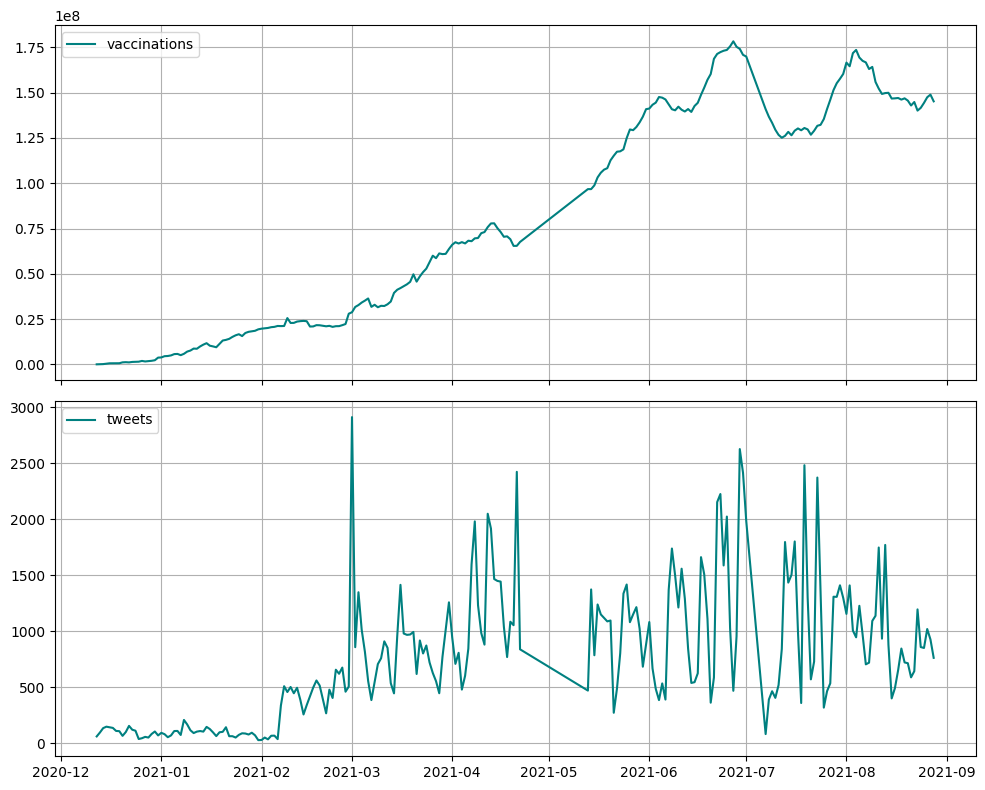

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(df.vaccinations, label = 'vaccinations', color='teal')
ax1.grid()
ax1.legend(loc='upper left')

ax2.plot(df.tweets, label = 'tweets', color='teal')
ax2.grid()
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

Для подбора параметра maxlag в grangercausalitytests будем использовать информационный критерий Акаике. Параметр maxlags в VAR.select_order примем равным корню из количества наблюдений.

In [7]:
model = VAR(df)
ic = model.select_order(maxlags=round(np.sqrt(len(df))))
print(ic.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        48.20       48.23   8.566e+20       48.21
1        42.39      42.48*   2.571e+18       42.43
2        42.36       42.52   2.503e+18      42.43*
3        42.35       42.57   2.469e+18       42.44
4       42.35*       42.62  2.462e+18*       42.46
5        42.37       42.71   2.527e+18       42.51
6        42.39       42.79   2.575e+18       42.55
7        42.39       42.86   2.582e+18       42.58
8        42.41       42.93   2.612e+18       42.62
9        42.43       43.01   2.665e+18       42.66
10       42.45       43.10   2.737e+18       42.71
11       42.42       43.13   2.652e+18       42.71
12       42.45       43.22   2.731e+18       42.76
13       42.45       43.28   2.734e+18       42.79
14       42.47       43.36   2.781e+18       42.83
15       42.47       43.43   2.803e+18       42.86
-------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Проверим Грейнджер-причинность количества вакцинаций на количество твитов.

Выдвинем нулевую гипотезу $H_0$ : "Прошлые значения временного ряда количества вакцинаций не дают прогностической информации для временного ряда количества твитов".

Альтернативная гипотеза $H_A$ : "Прошлые значения временного ряда количества вакцинаций дают прогностическую информацию для временного ряда количества твитов".

Примем уровень значимости $\alpha$ = 0.05

In [8]:
res = grangercausalitytests(df, maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7695  , p=0.1360  , df_denom=222, df_num=4
ssr based chi2 test:   chi2=7.3649  , p=0.1178  , df=4
likelihood ratio test: chi2=7.2499  , p=0.1233  , df=4
parameter F test:         F=1.7695  , p=0.1360  , df_denom=222, df_num=4


Во всех четырех тестах p-value > $\alpha$. Таким образом, нулевая гипотеза не может быть отвергнута на уровне значимости $\alpha$ = 0.05, соответственно прошлые значения временного ряда количества вакцинаций не дают прогностической информации для временного ряда количества твитов.

Проверим Грейнджер-причинность количества твитов на количество вакцинаций.

Выдвинем нулевую гипотезу $H_0$ : "Прошлые значения временного ряда количества твитов не дают прогностической информации для временного ряда количества вакцинаций".

Альтернативная гипотеза $H_A$ : "Прошлые значения временного ряда количества твитов дают прогностическую информацию для временного ряда количества вакцинаций".

Примем уровень значимости $\alpha$ = 0.05

In [9]:
res = grangercausalitytests(df.loc[:, ['tweets', 'vaccinations']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3195  , p=0.0022  , df_denom=222, df_num=4
ssr based chi2 test:   chi2=17.9784 , p=0.0012  , df=4
likelihood ratio test: chi2=17.3131 , p=0.0017  , df=4
parameter F test:         F=4.3195  , p=0.0022  , df_denom=222, df_num=4


Во всех четырех тестах p-value < $\alpha$. Таким образом, нулевая гипотеза отвергается на уровне значимости $\alpha$ = 0.05, соответственно прошлые значения временного ряда количества твитов дают прогностическую информацию для временного ряда количества вакцинаций.